In [1]:
import plotly.graph_objects as go
import networkx as nx
import os

# reading input log file

test_name = "ddmd"

stat_path=f"example_stat/{test_name}"
image_path=f"{stat_path}/images"



In [2]:
# My utility functions
import utils.stat_loader as sload
import utils.stat_print as sp
import utils.vfd_stat2graph as vfd2g
import utils.vfd_graph2sankey as vfd2sk
import utils.full_stat2graph as f2g

# Improve Functions
## TODO
- Add dataset nodes
- Add file address ordering nodes


In [3]:
STAGE_START = 0
STAGE_END = 1


TASK_ORDER_LIST = sload.load_task_order_list(stat_path)
STAGE_END = sload.correct_end_stage(TASK_ORDER_LIST, STAGE_END)

TASK_ORDER_LIST = sload.current_task_order_list(TASK_ORDER_LIST, STAGE_START, STAGE_END)

TASK_LISTS = list(TASK_ORDER_LIST.keys())

print(f"TASK_ORDER_LIST = {TASK_ORDER_LIST}")
TASK_LISTS


TASK_ORDER_LIST = {'openmm': 0, 'aggregate': 1}


['openmm', 'aggregate']

In [19]:
vfd_files = sload.find_files_with_pattern(stat_path, "vfd")
# vfd_files = vfd_files[0:1]
print(f"vfd_files: {vfd_files}")

vfd_dict = sload.load_stat_json(vfd_files)
# print(vfd_dict)


# vol_files = sload.find_files_with_pattern(stat_path, "vol")
# # vol_files = vol_files[0:1]
# print(f"vol_files: {vol_files}")

# vol_dict = sload.load_stat_json(vol_files)

print("loading json done")

vfd_files: ['example_stat/ddmd/378094-vfd_data_stat.json', 'example_stat/ddmd/378096-vfd_data_stat.json', 'example_stat/ddmd/378097-vfd_data_stat.json', 'example_stat/ddmd/378100-vfd_data_stat.json', 'example_stat/ddmd/378102-vfd_data_stat.json', 'example_stat/ddmd/378105-vfd_data_stat.json', 'example_stat/ddmd/378110-vfd_data_stat.json', 'example_stat/ddmd/378115-vfd_data_stat.json', 'example_stat/ddmd/378116-vfd_data_stat.json', 'example_stat/ddmd/378119-vfd_data_stat.json', 'example_stat/ddmd/378120-vfd_data_stat.json', 'example_stat/ddmd/378126-vfd_data_stat.json', 'example_stat/ddmd/379606-vfd_data_stat.json', 'example_stat/ddmd/379664-vfd_data_stat.json', 'example_stat/ddmd/379835-vfd_data_stat.json']
loading example_stat/ddmd/378094-vfd_data_stat.json
loading example_stat/ddmd/378096-vfd_data_stat.json
loading example_stat/ddmd/378097-vfd_data_stat.json
loading example_stat/ddmd/378100-vfd_data_stat.json
loading example_stat/ddmd/378102-vfd_data_stat.json
loading example_stat/dd

In [20]:
# Show VFD Tracker overhead
sp.show_all_overhead("VFD", vfd_dict)

Total VFD overhead: 3161455.5750000007 ms
Total POSIX IO time: 304234.6429999999 us
Total POSIX OPEN time: 29410.593999999994 us
Total POSIX CLOSE time: 10868.365000000002 us
Total POSIX READ time: 221179.11099999986 us
Total POSIX WRITE time: 42776.57300000005 us
Total POSIX DELETE time: 0.0 us


In [22]:
def inc_if_not_in_dict(dic, k):
    if k not in dic:
        dic[k] = 0
    else:
        dic[k]+=1

def add_task_dset_file_nodes(G, stat_dict, task_list):
    file_order_list = {} # keeptrack of dataset order in each file
    task_order_list = {}
    dset_order_list = {}
    file_page_map = {} # keep track of dataset page map in each file
    edge_stats = {} # All edge stats
    layer = 0
    added_file = []
    added_task = []
    
    for stat_file, stat_list in stat_dict.items():
        print(f"stat_file: {stat_file}")
        for li in stat_dict[stat_file]:
            k = list(li.keys())[0]
            if 'file' in k: # look for file entries
                stat = li[k]
                parts = k.split("-")
                node_order = int(parts[1])
                
                task_name = stat['task_name']
                # Extract taskname without PID: e.g. arldm_saveh5-1119693 tp arldm_saveh5
                task_name_base = task_name.split('-')[0]
                if task_name_base in list(task_list.keys()): # select task entries
                    

                    
                    parts = k.split("-")
                    node_name = f"{k} : {li[k]['file_name']}"
                    access_type = stat['access_type']
                    # file_name = stat['file_name']
                    file_name = os.path.basename(stat['file_name']) # FIXME: use basename for now
                    node_order = int(parts[1])
                    
                    file_stat = {"open_time": stat['open_time(us)'], "close_time": stat['close_time(us)'], 
                                 "file_intent": stat['file_intent'], 
                                 "file_read_cnt": stat['file_read_cnt'], 
                                 "file_write_cnt": stat['file_write_cnt'], 
                                 "access_type": stat['access_type'], "io_bytes": stat['io_bytes'], 
                                 "file_size": stat['file_size']}
                    
                    # Get used dataset statastics of this file
                    cur_dset_stats = f2g.get_all_dset_stat(stat)
                    
                    # Add file pages to file_page_map
                    dataset_page_map = f2g.dset_page_map(cur_dset_stats)
                    if file_name not in file_page_map:
                        file_page_map[file_name] = dataset_page_map
                    else:
                        for dset, pages in dataset_page_map.items():
                            if dset in file_page_map[file_name]:
                                file_page_map[file_name][dset].extend(pages)
                            else:
                                file_page_map[file_name][dset] = pages
                    
                    layer = task_list[task_name_base] * 3
                    # TODO: currently treat 'read_write' as 'write_only', 'read_write' as 'write_only'
                    if access_type == 'read_only': # Initial input files
                        
                        file_x = layer
                        addr_x = layer + 1
                        dset_x = layer + 2
                        task_x = layer + 3
                        # ORDER: file (-> file address) -> datasets -> task
                        if not G.has_node(file_name):
                            G.add_node(file_name, pos=(file_x,task_order_list[task_name_base]))
                            file_node_attrs = {file_name: {'rpos':0, 'order': node_order, 'type':'file'}} # no stat here
                            nx.set_node_attributes(G, file_node_attrs)
                            added_file.append(file_name)
                            
                        else:
                            # already has node, get x position as layer
                            layer= G.nodes[file_name]['pos'][0]

                        if not G.has_node(task_name):  # add task node
                            inc_if_not_in_dict(task_order_list, task_name_base)
                            G.add_node(task_name, pos=(task_x,task_order_list[task_name_base]))
                            # TODO: change to use VFD stats here
                            task_node_attrs = {task_name: {'rpos':0, 'order': node_order, 'type':'task'}}
                            nx.set_node_attributes(G, task_node_attrs)
                            

                        for dset, dset_stat in cur_dset_stats.items():
                            dset_node = f"{dset}-{layer}-R"
                            if not G.has_node(dset_node):
                                node_order = cur_dset_stats[dset]['order']
                                G.add_node(dset_node, pos=(dset_x,node_order))
                                node_type = 'dataset'
                                if dset == "file": node_type = 'file'
                                dset_node_attrs = {dset_node: {'rpos':1, 'order': node_order, 'type':node_type, 'stat': dset_stat}}
                                nx.set_node_attributes(G, dset_node_attrs)
                            ftd_attr = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'file_stat':file_stat, 'edge_type':'file-dset'}
                            if (file_name, dset_node) not in edge_stats:
                                edge_stats[(file_name, dset_node)] = ftd_attr
                            else:
                                edge_stats[(file_name, dset_node)].update(ftd_attr)
                            dtt_attr = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'file_stat':file_stat, 'edge_type':'dset-task'}
                            if (dset_node, task_name) not in edge_stats:
                                edge_stats[(dset_node, task_name)] = dtt_attr
                            else:
                                edge_stats[(dset_node, task_name)].update(dtt_attr)
                            
                            # edge_stats[(file_name, dset_node)] = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'stat':file_stat, 'edge_type':'file_to_dset'}                          
                            # edge_stats[(dset_node, task_name)] = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'stat':file_stat, 'edge_type':'dset_to_task'}
                        
                    elif access_type == 'write_only' or access_type == 'read_write': # Intermediate files
                        # ORDER: task -> datasets (-> file address) -> file
                        file_x = layer + 3
                        addr_x = layer + 2
                        dset_x = layer + 1
                        task_x = layer
                        if not G.has_node(task_name):  # add task node
                            inc_if_not_in_dict(task_order_list, task_name_base)
                            G.add_node(task_name, pos=(task_x,task_order_list[task_name_base]))
                            # TODO: change to use VFD stats here
                            task_node_attrs = {task_name: {'rpos':0, 'order': node_order, 'type':'task'}}
                            nx.set_node_attributes(G, task_node_attrs)
                            added_task.append(task_name)
                        else:
                            # already has node, get x position as layer
                            layer= G.nodes[task_name]['pos'][0]
                        
                        if not G.has_node(file_name):
                            G.add_node(file_name, pos=(file_x,task_order_list[task_name_base]))
                            file_node_attrs = {file_name: {'rpos':0, 'order': node_order, 'type':'file'}} # no stat here
                            nx.set_node_attributes(G, file_node_attrs)
                        
                        for dset, dset_stat in cur_dset_stats.items():
                            dset_node = f"{dset}-{layer}-W"
                            if not G.has_node(dset_node):
                                node_order = cur_dset_stats[dset]['order']
                                G.add_node(dset_node, pos=(dset_x,node_order))
                                node_type='dataset'
                                if dset == "file": node_type = 'file'
                                dset_node_attrs = {dset_node: {'rpos':1, 'order': node_order, 'type':node_type, 'stat': dset_stat}}
                                nx.set_node_attributes(G, dset_node_attrs)
                            ttd_attr = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'file_stat':file_stat, 'edge_type':'task-dset'}
                            if (task_name, dset_node) not in edge_stats:
                                edge_stats[(task_name, dset_node)] = ttd_attr
                            else:
                                edge_stats[(task_name, dset_node)].update(ttd_attr)
                            dtf_attr = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'file_stat':file_stat, 'edge_type':'dset-file'}
                            if (dset_node, file_name) not in edge_stats:
                                edge_stats[(dset_node, file_name)] = dtf_attr
                            else:
                                edge_stats[(dset_node, file_name)].update(dtf_attr)

                            # edge_stats[(task_name, dset_node)] = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'stat':file_stat, 'edge_type':'task_to_dset'}
                            # edge_stats[(dset_node, file_name)] = {'label':task_name, 'dset_stat':dset_stat, 'access_type':access_type, 'stat':file_stat, 'edge_type':'dset_to_file'}
                    
    G.add_edges_from(edge_stats.keys())
    nx.set_edge_attributes(G, edge_stats)
    return G

G_VFD = nx.DiGraph()
G_VFD = add_task_dset_file_nodes(G_VFD, vfd_dict, TASK_ORDER_LIST)

# sp.display_all_edges_attr(G_VFD)
sp.display_all_nodes_position(G_VFD)

stat_file: example_stat/ddmd/378094-vfd_data_stat.json


KeyError: 'openmm'

In [7]:
def add_file_page(G, file_page_nodes_attr, dset_page_edges):
    add_edge_stat = {}
    edges_to_remove = []
    nodes_to_add = {}
    
    for edge in G.edges():
        edge_stat = G.edges[edge]
        
        if edge_stat['edge_type'] == 'file-dset': # read
            # print(f"edge: {edge} -> {edge_stat['dset_stat']}")
            access_type = edge_stat['access_type']
            edges_to_remove.append(edge)
            file_name = edge[0]
            dset_name = edge[1]
            layer = 0
            for page_dset_edge in dset_page_edges:
                new_edge_stat = dset_page_edges[page_dset_edge]
                page = page_dset_edge[0]
                page_name = f"{page}-{layer}-R"                    
                new_dset_name = f"{page_dset_edge[1]}-{layer}-R"
                if new_dset_name == dset_name:
                    # print(f"new_edge: {new_edge}")
                    if not G.has_node(page_name):
                        node_x = G.nodes[file_name]['pos'][0] + 1 # after file nodes
                        node_order = file_page_nodes_attr[page]['pos'][1]
                        nodes_to_add[page_name] = {page_name: {'pos':(node_x,node_order) , 'rpos':1, 'order': node_order, 'type':'addr', 'size': file_page_nodes_attr[page]['size'], 'range': file_page_nodes_attr[page]['range']}}
                        page_stat = {'size': file_page_nodes_attr[page]['size'], 'range': file_page_nodes_attr[page]['range'], 'access_cnt': dset_page_edges[page_dset_edge]['access_cnt']}
                        # Add page to dset edge
                        add_edge_stat[(page_name, new_dset_name)] = {'label':edge_stat['label'], 
                                     'access_type':access_type, 
                                     'page_stat':page_stat,
                                     'edge_type':'page-dset',
                                     'file_stat':edge_stat['file_stat'],
                                     'dset_stat':edge_stat['dset_stat']} 
                        # Add file to page edge
                        add_edge_stat[(file_name, page_name)] = {'label':edge_stat['label'], 
                                     'access_type':access_type, 
                                     'page_stat':page_stat,
                                     'edge_type':'file-page',
                                     'file_stat':edge_stat['file_stat'],
                                     'dset_stat':edge_stat['dset_stat']} 
                        
        if edge_stat['edge_type'] == 'dset-file': # write
            access_type = edge_stat['access_type']
            edges_to_remove.append(edge)
            file_name = edge[1]
            dset_name = edge[0]
            
            for page_dset_edge in dset_page_edges:
                new_edge_stat = dset_page_edges[page_dset_edge]
                page = page_dset_edge[1]
                page_name = f"{page}-{layer}-W"
                new_dset_name = f"{page_dset_edge[0]}-{layer}-W"
                if new_dset_name == dset_name:
                    # print(f"new_edge: {new_edge}")
                    if not G.has_node(page_name):
                        node_x = G.nodes[dset_name]['pos'][0] + 1 # after dset nodes
                        node_order = file_page_nodes_attr[page]['pos'][1]
                        nodes_to_add[page_name] = {page_name: {'pos':(node_x,node_order) , 'rpos':1, 'order': node_order, 'type':'addr', 'size': file_page_nodes_attr[page]['size'], 'range': file_page_nodes_attr[page]['range']}}
                        page_stat = {'size': file_page_nodes_attr[page]['size'], 'range': file_page_nodes_attr[page]['range'], 'access_cnt': dset_page_edges[page_dset_edge]['access_cnt']}
                        # Add page to dset edge
                        add_edge_stat[(new_dset_name, page_name)] = {'label':edge_stat['label'], 
                                     'access_type':access_type, 
                                     'page_stat':page_stat,
                                     'edge_type':'dset-page',
                                     'file_stat':edge_stat['file_stat'],
                                     'dset_stat':edge_stat['dset_stat']}
                        # Add file to page edge
                        add_edge_stat[(page_name, file_name)] = {'label':edge_stat['label'], 
                                     'access_type':access_type, 
                                     'page_stat':page_stat,
                                     'edge_type':'page-file',
                                     'file_stat':edge_stat['file_stat'],
                                     'dset_stat':edge_stat['dset_stat']} 
    

    
    return add_edge_stat, edges_to_remove, nodes_to_add



file_page_nodes_attr, dset_page_edges = f2g.get_file_dset_maps(vfd_dict, TASK_LISTS)
add_edge_stat,edges_to_remove,nodes_to_add = add_file_page(G_VFD, file_page_nodes_attr, dset_page_edges)
# for k,v in add_edge_stat.items():
#     print(f"add_edge_stat: {k} -> {v}")
print(f"edges_to_add: {add_edge_stat.keys()}")
print(f"edges_to_remove: {edges_to_remove}")
G_VFD = f2g.update_nodes_edges(G_VFD,add_edge_stat, edges_to_remove, nodes_to_add)

stat_file: example_stat/ddmd/378094-vfd_data_stat.json
stat_file: example_stat/ddmd/378096-vfd_data_stat.json
stat_file: example_stat/ddmd/378097-vfd_data_stat.json
stat_file: example_stat/ddmd/378100-vfd_data_stat.json
stat_file: example_stat/ddmd/378102-vfd_data_stat.json
stat_file: example_stat/ddmd/378105-vfd_data_stat.json
stat_file: example_stat/ddmd/378110-vfd_data_stat.json
stat_file: example_stat/ddmd/378115-vfd_data_stat.json
stat_file: example_stat/ddmd/378116-vfd_data_stat.json
stat_file: example_stat/ddmd/378119-vfd_data_stat.json
stat_file: example_stat/ddmd/378120-vfd_data_stat.json
stat_file: example_stat/ddmd/378126-vfd_data_stat.json
stat_file: example_stat/ddmd/379606-vfd_data_stat.json
stat_file: example_stat/ddmd/379664-vfd_data_stat.json
stat_file: example_stat/ddmd/379835-vfd_data_stat.json


file_page_nodes_attr: {'[0-5)': {'pos': (0, 0), 'rpos': 0, 'range': (0, 5), 'size': 327680}, '[5-10)': {'pos': (0, 1), 'rpos': 0, 'range': (5, 10), 'size': 327680}, '[10-15)': {'pos': (0, 2), 'rpos': 0, 'range': (10, 15), 'size': 327680}, '[15-20)': {'pos': (0, 3), 'rpos': 0, 'range': (15, 20), 'size': 327680}}
dset_page_edges: {('[0-5)', 'contact_map'): {'access_cnt': 72, 'access_type': 'read'}, ('contact_map', '[0-5)'): {'access_cnt': 2400, 'access_type': 'write'}, ('contact_map', '[5-10)'): {'access_cnt': 98, 'access_type': 'write'}, ('contact_map', '[10-15)'): {'access_cnt': 140, 'access_type': 'write'}, ('contact_map', '[15-20)'): {'access_cnt': 128, 'access_type': 'write'}, ('[0-5)', 'file'): {'access_cnt': 96, 'access_type': 'read'}, ('file', '[0-5)'): {'access_cnt': 194, 'access_type': 'write'}, ('fnc', '[0-5)'): {'access_cnt': 2400, 'access_type': 'write'}, ('[0-5)', 'point_cloud'): {'access_cnt': 1514, 'access_type': 'read'}, ('point_cloud', '[0-5)'): {'access_cnt': 1463, 'ac

In [8]:
task_file_map = sload.load_task_file_map(stat_path, test_name, TASK_LISTS)

for task, stat in task_file_map.items():
    print(f"{task} : {stat}")



task_file_map = {'openmm-378094': {'order': 0, 'io_cnt': 424, 'input': [], 'output': ['/mnt/nvme/mtang11/ddmd_test/molecular_dynamics_runs/stage0000/task0001/stage0000_task0001.h5']}, 'openmm-378096': {'order': 0, 'io_cnt': 424, 'input': [], 'output': ['/mnt/nvme/mtang11/ddmd_test/molecular_dynamics_runs/stage0000/task0000/stage0000_task0000.h5']}, 'openmm-378097': {'order': 0, 'io_cnt': 424, 'input': [], 'output': ['/mnt/nvme/mtang11/ddmd_test/molecular_dynamics_runs/stage0000/task0002/stage0000_task0002.h5']}, 'openmm-378100': {'order': 0, 'io_cnt': 424, 'input': [], 'output': ['/mnt/nvme/mtang11/ddmd_test/molecular_dynamics_runs/stage0000/task0004/stage0000_task0004.h5']}, 'openmm-378102': {'order': 0, 'io_cnt': 424, 'input': [], 'output': ['/mnt/nvme/mtang11/ddmd_test/molecular_dynamics_runs/stage0000/task0003/stage0000_task0003.h5']}, 'openmm-378105': {'order': 0, 'io_cnt': 424, 'input': [], 'output': ['/mnt/nvme/mtang11/ddmd_test/molecular_dynamics_runs/stage0000/task0005/stage00

In [9]:
# G_VFD = vfd2g.set_task_position_full(G_VFD, task_file_map, STAGE_START)
# sp.display_all_nodes_attr(G_VFD)
all_edge_types = nx.get_edge_attributes(G_VFD,'edge_type')
edge_types = []
for edge in all_edge_types:
    edge_types.append(all_edge_types[edge])

print(f"edge_types: {set(edge_types)}")

edge_types: {'task-dset', 'dset-task'}


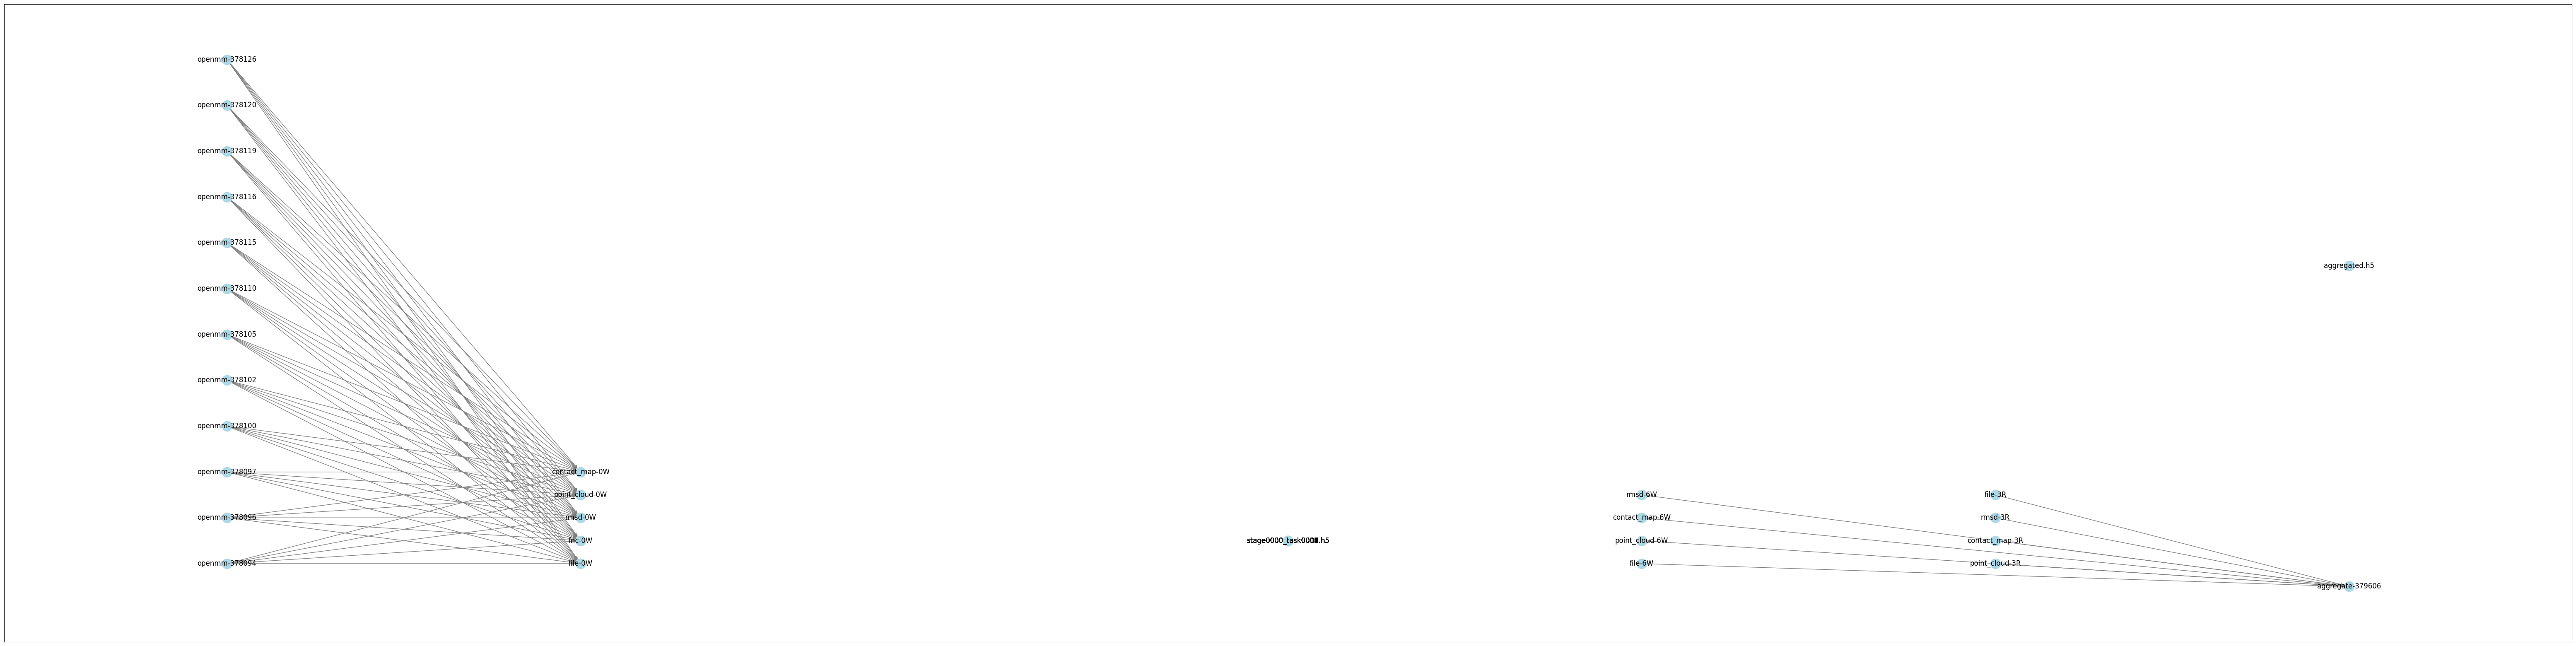

In [10]:
# sp.display_all_nodes_attr(G_VFD)
# G_VFD = vfd2g.set_file_position(G_VFD, task_file_map)


sp.draw_graph(G_VFD, test_name, stat_path, graph_type="vfd", prefix=f'{(STAGE_END+1)}s', save=True)

In [11]:
# sp.display_all_edges_attr(G_VFD)
sp.display_all_nodes_position(G_VFD)

Node Name: openmm-378094 - Position: (0, 1)
Node Name: stage0000_task0001.h5 - Position: (3, 2)
Node Name: contact_map-0W - Position: (1, 5)
Node Name: file-0W - Position: (1, 1)
Node Name: fnc-0W - Position: (1, 2)
Node Name: point_cloud-0W - Position: (1, 4)
Node Name: rmsd-0W - Position: (1, 3)
Node Name: openmm-378096 - Position: (0, 3)
Node Name: stage0000_task0000.h5 - Position: (3, 2)
Node Name: openmm-378097 - Position: (0, 5)
Node Name: stage0000_task0002.h5 - Position: (3, 2)
Node Name: openmm-378100 - Position: (0, 7)
Node Name: stage0000_task0004.h5 - Position: (3, 2)
Node Name: openmm-378102 - Position: (0, 9)
Node Name: stage0000_task0003.h5 - Position: (3, 2)
Node Name: openmm-378105 - Position: (0, 11)
Node Name: stage0000_task0005.h5 - Position: (3, 2)
Node Name: openmm-378110 - Position: (0, 13)
Node Name: stage0000_task0006.h5 - Position: (3, 2)
Node Name: openmm-378115 - Position: (0, 15)
Node Name: stage0000_task0009.h5 - Position: (3, 2)
Node Name: openmm-378116 -

# Add networkx to Sankey diagram

## Statistics for Sankey
Below are needed edge attributes before generating the sankey diagram:
- access_cnt : The total file/dataset access count 
- access_size : The total read and write access size
- operation : The operation type : read, write, read_write
- bandwidth : Get the per access size and time, then calculate the bandwidth. Average the bandwidth if multiple accesses. (TODO: currently only recording one access size and time)




In [12]:
def prepare_sankey_stat_full(G):
    sankey_edge_attr = {}
    for edge in G.edges():
        edge_type = G.edges[edge]['edge_type']

        data_access_bytes = 0
        data_access_cnt = 0
        metadata_access_bytes = 0
        metadata_access_cnt = 0
        bandwidth = 0
        file_stat = G.edges[edge]['file_stat']
        # edge_types: {'dset-task', 'page-file', 'page-dset', 'file-page', 'dset-page', 'task-dset'}
        if edge_type == 'dset-task' or edge_type == 'task-dset':
            # print(f"edge: {edge} -> {stat}")
            # want dataset size access info only
            dset_stat = G.edges[edge]['dset_stat']
            position = G.nodes[edge[1]]['pos']
            
            for meta_type in dset_stat['metadata']:
                meta_stat = dset_stat['metadata'][meta_type]
                metadata_access_bytes += meta_stat['read_bytes'] + meta_stat['write_bytes']
                metadata_access_cnt += meta_stat['read_cnt'] + meta_stat['write_cnt']
            for data_type in dset_stat['data']:
                data_stat = dset_stat['data'][data_type]
                data_access_bytes += data_stat['read_bytes'] + data_stat['write_bytes']
                data_access_cnt += data_stat['read_cnt'] + data_stat['write_cnt']
            
            access_time_in_sec = 0.0001 # set to a large value as in memory access (0.1ms)
            access_cnt = metadata_access_cnt + data_access_cnt
            access_size = metadata_access_bytes + data_access_bytes
            bandwidth = access_size / access_time_in_sec
            
        elif edge_type == 'page-file' or edge_type == 'file-page':
            # want page size access info and file info
            page_stat = G.edges[edge]['page_stat']
            position = G.nodes[edge[1]]['pos']
            access_cnt = page_stat['access_cnt']
            access_size = page_stat['size']
            
            access_time_in_sec = (file_stat['close_time'] - file_stat['open_time'])/1000000
            bandwidth = access_cnt * access_size / access_time_in_sec
            
            
        elif edge_type == 'dset-page' or edge_type == 'page-dset':
            # want page size access info only
            dset_stat = G.edges[edge]['dset_stat']
            position = G.nodes[edge[1]]['pos']
            
            for meta_type in dset_stat['metadata']:
                meta_stat = dset_stat['metadata'][meta_type]
                metadata_access_bytes += meta_stat['read_bytes'] + meta_stat['write_bytes']
                metadata_access_cnt += meta_stat['read_cnt'] + meta_stat['write_cnt']
            for data_type in dset_stat['data']:
                data_stat = dset_stat['data'][data_type]
                data_access_bytes += data_stat['read_bytes'] + data_stat['write_bytes']
                data_access_cnt += data_stat['read_cnt'] + data_stat['write_cnt']
                
            page_stat = G.edges[edge]['page_stat']
            position = G.nodes[edge[1]]['pos']
            
            access_cnt = metadata_access_cnt + data_access_cnt #page_stat['access_cnt']
            access_size = page_stat['size']
            
            access_time_in_sec = (file_stat['close_time'] - file_stat['open_time'])/1000000 # change to dataset open and close time
            bandwidth = access_cnt * access_size / access_time_in_sec

        else:
            # set all values to 0
            position = (0,0)
            access_cnt = 0
            access_size = 0
        
        edge_attr = {
                'position': position,
                'access_cnt': access_cnt,
                'access_size': access_size,
                'data_access_size': data_access_bytes,
                'data_access_cnt': data_access_cnt,
                'metadata_access_size': metadata_access_bytes,
                'metadata_access_cnt': metadata_access_cnt,
                'bandwidth': bandwidth,
                'operation': file_stat['access_type'],}
        sankey_edge_attr[edge] = edge_attr
    
    nx.set_edge_attributes(G, sankey_edge_attr)

# f2g.prepare_sankey_stat_full(G_VFD)
prepare_sankey_stat_full(G_VFD)

In [13]:
vfd2sk.time_to_file_x_pos(G_VFD)

All tasks:  ['openmm-378094', 'openmm-378096', 'openmm-378097', 'openmm-378100', 'openmm-378102', 'openmm-378105', 'openmm-378110', 'openmm-378115', 'openmm-378116', 'openmm-378119', 'openmm-378120', 'openmm-378126', 'aggregate-379606']
contact_map-3R New pos:  (5.25, 2)
file-3R New pos:  (5.25, 4)
point_cloud-3R New pos:  (5.25, 1)
rmsd-3R New pos:  (5.25, 3)
contact_map-6W New pos:  (3.75, 3)
file-6W New pos:  (3.75, 1)
point_cloud-6W New pos:  (3.75, 2)
rmsd-6W New pos:  (3.75, 4)


In [14]:
vfd_nodes, vfd_nodes_dict = vfd2sk.get_nodes_for_sankey(G_VFD, label_on=True)

# print(vfd_nodes)

vfd_links = vfd2sk.get_links_for_sankey(G_VFD, vfd_nodes_dict, val_sqrt=False)
fig = go.Figure(go.Sankey(
            node = vfd_nodes,
            link = vfd_links, orientation='h'))

width = 2000
height = 800

fig.update_layout(
    autosize=False,
    width=width,
    height=height,
    margin=dict(
        l=width/100,
        r=width/50,
        b=height/100,
        t=height/5,
        pad=2
    ),
    font=dict(size=18),
)


fig.show()
save_html_path = f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-labeled-s4.html"
fig.write_html(save_html_path)
print(f"Sankey saved to {save_html_path}")

bandwidth range: 480 KB/s ~ 15.47 GB/s


Sankey saved to example_stat/ddmd/vfd-2s-ddmd-sankey-labeled-s4.html


In [15]:
stat_str = sp.show_vfd_stats(G_VFD)
print(stat_str)



Total number of links: 68
Total I/O size: 3.68 MB
Total I/O count: 9196
Total bandwidth: 36.84 GB/s
Average I/O size: 400.66 B
Medium I/O size: 1.6 KB
Inital input size: 0



In [16]:
# Create a manual legend using annotations.

def add_legend_to_graph(fig,save_img=False):
    LEGEND_ITEMS = {
        "Tasks":{"color":"red", "text":"Tasks"},
        "Files":{"color":"blue", "text":"Files"},
        "Edges":{"color":"lightblue", "text":"File bandwidth, darker the color, higher the bandwidth"},
    }

    legend_items = [
        go.layout.Annotation(
            x=0.9,  # X-coordinate for legend item
            y=0.85 - i * 0.03,  # Y-coordinate for legend item (adjust for position)
            xref='paper',
            yref='paper',
            text=f"{item_type} - {LEGEND_ITEMS[item_type]['color']}",
            showarrow=False,
            font=dict(size=14, color=LEGEND_ITEMS[item_type]['color']),
            # bordercolor='grey',  # Set the border color for the legend box
            # borderwidth=1,  # Set the border width for the legend box
            bgcolor='rgba(255, 255, 255, 0.7)',  # Add a transparent background color
        )
        for i, item_type in enumerate(LEGEND_ITEMS.keys())
    ]
    fig.update_layout(annotations=legend_items)
    fig.show()
    if save_img:
        fig.write_html(f"{stat_path}/vfd-{(STAGE_END+1)}s-{test_name}-sankey-annotated.html")
